# Foreword & Remarks

- This work was adapted from the 1st place solution of the Jigsaw 2020 competition: https://www.kaggle.com/rafiko1/1st-place-jigsaw-post-processing-example
- First place post-processing details can be found at: https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/discussion/160862. Main idea was to track the delta of predictions for each sample using successful submissions, then averaging them and 'pushing' the predictions in the same direction.
- I only configured it a little bit so that it can be used in this competition
- This notebook uses **only public notebook submission files**!! For me, using my ensemble as the "best sub" with minor tweaks to give a small boost in LB
- Since we are allowed to make 3 final submissions, if you are willing to risk it, feel free to have a submission that uses this pipeline

# Update Log

- **Version 6**: As per Chris' feedback, submisison dataframes are now sorted before their predictions are concatenated to the test dataframe. Also changed a public sub to another one as the submission could no longer be extracted. 

# Imports

In [1]:
# General imports
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

In [2]:
WEIGHT = 1 # best to keep between 1 and 2 from the orignal authors

In [3]:
submission = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
test = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
sub_best = pd.read_csv('../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled.csv')

In [4]:
files_sub = [
    '../input/minmax-ensemble-0-9526-lb/submission.csv',
    '../input/new-basline-np-log2-ensemble-top-10/submission.csv',
    '../input/stacking-ensemble-on-my-submissions/submission_mean.csv',
    '../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled.csv',
    '../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled.csv',
    '../input/submission-exploration/submission.csv',
    '../input/rc-fork-siim-isic-melanoma-384x384/sub_EfficientNetB2_384.csv',
    '../input/train-cv/submission.csv',
    '../input/triple-stratified-kfold-with-tfrecords/submission.csv',
    '../input/rank-then-blend/blend_sub.csv',
    '../input/siim-isic-melanoma-classification-ensemble/submission.csv'
]
files_sub = sorted(files_sub)
print(len(files_sub))
files_sub

11


['../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled.csv',
 '../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled.csv',
 '../input/minmax-ensemble-0-9526-lb/submission.csv',
 '../input/new-basline-np-log2-ensemble-top-10/submission.csv',
 '../input/rank-then-blend/blend_sub.csv',
 '../input/rc-fork-siim-isic-melanoma-384x384/sub_EfficientNetB2_384.csv',
 '../input/siim-isic-melanoma-classification-ensemble/submission.csv',
 '../input/stacking-ensemble-on-my-submissions/submission_mean.csv',
 '../input/submission-exploration/submission.csv',
 '../input/train-cv/submission.csv',
 '../input/triple-stratified-kfold-with-tfrecords/submission.csv']

In [5]:
for file in files_sub:
    test[file.replace(".csv", "")] = pd.read_csv(file).sort_values('image_name')["target"]
test['id'] = test.index

In [6]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled,../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled,../input/minmax-ensemble-0-9526-lb/submission,../input/new-basline-np-log2-ensemble-top-10/submission,../input/rank-then-blend/blend_sub,../input/rc-fork-siim-isic-melanoma-384x384/sub_EfficientNetB2_384,../input/siim-isic-melanoma-classification-ensemble/submission,../input/stacking-ensemble-on-my-submissions/submission_mean,../input/submission-exploration/submission,../input/train-cv/submission,../input/triple-stratified-kfold-with-tfrecords/submission,id
0,ISIC_0052060,IP_3579794,male,70.0,NaN,0.028636,0.035168,0.000153,0.000021,0.452031,0.035619,0.442216,0.022257,0.022904,0.019561,0.027359,0
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.025085,0.026585,0.000118,0.000013,0.200596,0.030290,0.198324,0.016384,0.018993,0.028645,0.025799,1
2,ISIC_0058510,IP_7960270,female,55.0,torso,0.024785,0.028502,0.002049,0.000281,0.165812,0.020130,0.164583,0.023354,0.018233,0.022637,0.025983,2
3,ISIC_0073313,IP_6375035,female,50.0,torso,0.025986,0.030733,0.000135,0.000015,0.110636,0.021280,0.111062,0.017497,0.016989,0.021303,0.024942,3
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.032871,0.032410,0.000448,0.000044,0.531879,0.161430,0.519997,0.018092,0.022621,0.018570,0.032569,4


In [7]:
test.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge',
       '../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled',
       '../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled',
       '../input/minmax-ensemble-0-9526-lb/submission',
       '../input/new-basline-np-log2-ensemble-top-10/submission',
       '../input/rank-then-blend/blend_sub',
       '../input/rc-fork-siim-isic-melanoma-384x384/sub_EfficientNetB2_384',
       '../input/siim-isic-melanoma-classification-ensemble/submission',
       '../input/stacking-ensemble-on-my-submissions/submission_mean',
       '../input/submission-exploration/submission',
       '../input/train-cv/submission',
       '../input/triple-stratified-kfold-with-tfrecords/submission', 'id'],
      dtype='object')

In [8]:
# Derive the given sub increases or decreases in score
test["diff_good1"] =  test['../input/rank-then-blend/blend_sub'] - test['../input/triple-stratified-kfold-with-tfrecords/submission']
test["diff_good1"] =  test['../input/train-cv/submission'] - test['../input/siim-isic-melanoma-classification-ensemble/submission']
test["diff_good2"] = test['../input/rc-fork-siim-isic-melanoma-384x384/sub_EfficientNetB2_384'] - test['../input/submission-exploration/submission']
test["diff_good3"] = test['../input/analysis-of-melanoma-metadata-and-effnet-ensemble/ensembled'] - test['../input/new-basline-np-log2-ensemble-top-10/submission']

test["diff_bad1"] = test['../input/stacking-ensemble-on-my-submissions/submission_mean'] - test['../input/minmax-ensemble-0-9526-lb/submission']

In [9]:
test["sub_best"] = test['../input/eda-modelling-of-the-external-data-inc-ensemble/external_meta_ensembled']
col_comment = ["id", "image_name", "patient_id", "sub_best"]
col_diff = [column for column in test.columns if "diff" in column]
test_diff = test[col_comment + col_diff].reset_index(drop=True)

test_diff["diff_avg"] = test_diff[col_diff].mean(axis=1) # the mean trend

In [10]:
# Apply the post-processing technique in one line (as explained in the pseudo-code of my post.
test_diff["sub_new"] = test_diff.apply(lambda x: (1+WEIGHT*x["diff_avg"])*x["sub_best"] if x["diff_avg"]<0 else (1-WEIGHT*x["diff_avg"])*x["sub_best"] + WEIGHT*x["diff_avg"] , axis=1)

In [11]:
submission["target"] = sub_best["target"]
submission.head()

,image_name,target
0,ISIC_0052060,0.035168
1,ISIC_0052349,0.026585
2,ISIC_0058510,0.028502
3,ISIC_0073313,0.030733
4,ISIC_0073502,0.032410


In [12]:
test_diff.head()

,id,image_name,patient_id,sub_best,diff_good1,diff_good2,diff_good3,diff_bad1,diff_avg,sub_new
0,0,ISIC_0052060,IP_3579794,0.035168,-0.422655,0.012715,0.028615,0.022104,-0.089805,0.032010
1,1,ISIC_0052349,IP_7782715,0.026585,-0.169679,0.011297,0.025072,0.016266,-0.029261,0.025807
2,2,ISIC_0058510,IP_7960270,0.028502,-0.141946,0.001897,0.024504,0.021305,-0.023560,0.027831
3,3,ISIC_0073313,IP_6375035,0.030733,-0.089759,0.004291,0.025971,0.017362,-0.010534,0.030409
4,4,ISIC_0073502,IP_0589375,0.032410,-0.501427,0.138808,0.032827,0.017644,-0.078037,0.029881


In [13]:
submission.loc[test["id"], "target"] = test_diff["sub_new"].values

In [14]:
submission.to_csv("submission.csv", index=False)
submission.head()

,image_name,target
0,ISIC_0052060,0.032010
1,ISIC_0052349,0.025807
2,ISIC_0058510,0.027831
3,ISIC_0073313,0.030409
4,ISIC_0073502,0.029881


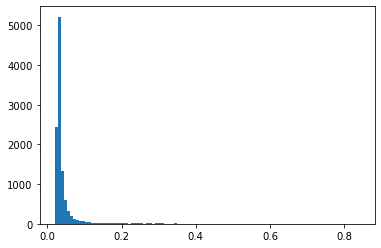

In [15]:
plt.hist(submission.target,bins=100)
plt.show()